## Classify and plot dimensionless profiles

# Generate summary profiles
Run cluster analysis on the profiles to identify clusters of events with similar profiles.  
This is performed on the cumulative, normalised rainfall profiles.  
The objective is to group similar rainfall events based on how rainfall accumulates over time (regardless of individual intensities or durations).  
The output of this is centroids which represent the average cumulative profile of each cluster.   

### Convert cumulative rainfall data into intensity profiles
This is to better illustrate the characteristic behaviours/patterns revealed by clusters.  

This involves:  
- Converting cumulative rainfall to intensities (differentiating the cumulative rainfall with respect to time to obtain instantaneous rainfall intensities?)
- Normalising these intensities by a characteristic intensity, often the average intensity of each profile or the peak intensity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt    
import re
import pickle
import matplotlib.patches as mpatches

from Analyse_Events_Functions import *
from PlotEvents import *

## Compare the 3 NIMROD options for 1km for 5, 10, 15, 20 clusters

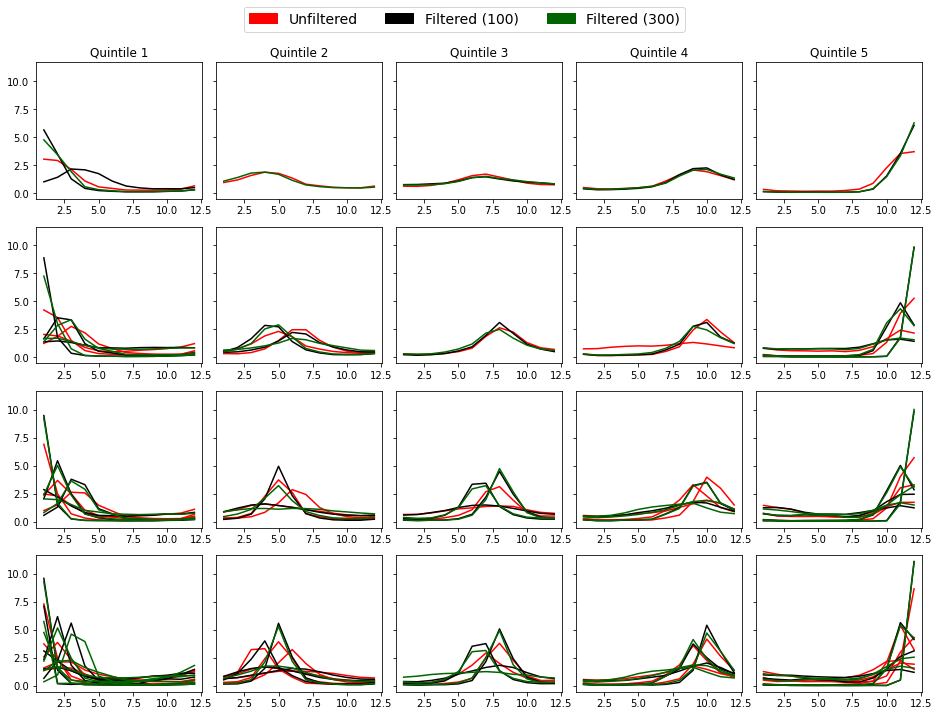

In [7]:
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13, 10), sharey=True)
# # Define the number of clusters for each row
num_clusters_list = [5, 10, 15, 20]

# Loop through the number of clusters and plot profiles
for row, num_clusters in enumerate(num_clusters_list):
#     plot_profiles(axs, "UKCP18_30mins/model_profiles","UKCP18_30mins/model_durations_for_profiles",
#                   "UKCP18_30mins/model_volumes_for_profiles", "UKCP18_30mins/model_real_durations_for_profiles",num_clusters, row, color="black", linestyle='solid')
    plot_profiles(axs, "NIMROD/NIMROD_1km_unfiltered_profiles","NIMROD/NIMROD_1km_unfiltered_durations_for_profiles",
                  "NIMROD/NIMROD_1km_unfiltered_real_durations_for_profiles",
                  "NIMROD/NIMROD_1km_unfiltered_volumes_for_profiles", 
                  num_clusters, row, color='red', linestyle='solid')
    plot_profiles(axs, "NIMROD/NIMROD_1km_filtered_100_profiles","NIMROD/NIMROD_1km_filtered_100_durations_for_profiles",
                  "NIMROD/NIMROD_1km_filtered_100_volumes_for_profiles", "NIMROD/NIMROD_1km_filtered_100_real_durations_for_profiles",
                  num_clusters, row, color='black', linestyle='solid')
    plot_profiles(axs, "NIMROD/NIMROD_1km_filtered_300_profiles","NIMROD/NIMROD_1km_filtered_300_durations_for_profiles",
                  "NIMROD/NIMROD_1km_filtered_300_volumes_for_profiles", "NIMROD/NIMROD_1km_filtered_300_real_durations_for_profiles",
                  num_clusters, row, color='darkgreen', linestyle='solid')    


# Define the legend patches
red_patch = mpatches.Patch(color='red', label='Unfiltered')
black_patch = mpatches.Patch(color='black', label='Filtered (100)')
green_patch = mpatches.Patch(color='darkgreen', label='Filtered (300)')

# Adjust the layout to make space for the legend
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Add the legend to the figure
fig.legend(handles=[red_patch, black_patch, green_patch], loc='upper center', fontsize = 14, bbox_to_anchor=(0.5, 1), ncol=3)

# Show the plot
plt.show()



## Compare one of the NIMROD options to the RVH profiles for short durations

In [12]:
# Read in profiles
rvh_profiles = pd.read_csv("../CatchmentAnalysis/CreateSyntheticRainfallEvents/ObservedProfiles/kmeans_15clustersPerDur.csv")
# # Just keep prain (proportion of rainfall in each timestep)
rvh_profiles = rvh_profiles[rvh_profiles['Variable'] == 'irain']
rvh_profiles = rvh_profiles[rvh_profiles['Duration'] == '[2:10 - 6:45) hr']

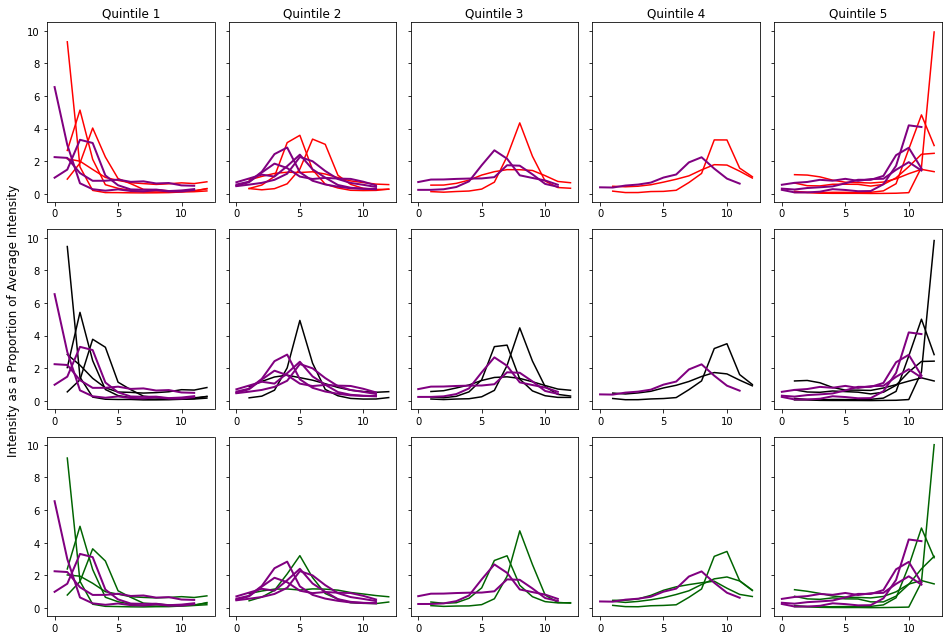

In [20]:
# Create the subplots (one row with 5 columns)
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(13, 9), sharey=True)

# Plot profiles for a specific number of clusters
plot_profiles(axs, "NIMROD/NIMROD_1km_unfiltered_profiles", "NIMROD/NIMROD_1km_unfiltered_durations_for_profiles",
               "NIMROD/NIMROD_1km_unfiltered_volumes_for_profiles",  "NIMROD/NIMROD_1km_unfiltered_real_durations_for_profiles",
              15,0 ,color='red', linestyle='solid') 
plot_profiles(axs, "NIMROD/NIMROD_1km_filtered_100_profiles", "NIMROD/NIMROD_1km_filtered_100_durations_for_profiles",
               "NIMROD/NIMROD_1km_filtered_100_volumes_for_profiles",  "NIMROD/NIMROD_1km_filtered_100_real_durations_for_profiles",
              15,1 ,color='black', linestyle='solid') 
plot_profiles(axs, "NIMROD/NIMROD_1km_filtered_300_profiles", "NIMROD/NIMROD_1km_filtered_300_durations_for_profiles",
               "NIMROD/NIMROD_1km_filtered_300_volumes_for_profiles",  "NIMROD/NIMROD_1km_filtered_300_real_durations_for_profiles",
              15,2 ,color='darkgreen', linestyle='solid') 

for cluster_num in range(1,14):
    cluster1=rvh_profiles[rvh_profiles['Cluster']==cluster_num]
    cluster1 = cluster1[:-2]
    quintile_with_max_value = find_quintile_with_max_value(np.array(cluster1['Mean']))
    axs[0,quintile_with_max_value].plot(range(len(cluster1)),cluster1['Mean'], linewidth = 2, color='purple')   
    axs[1,quintile_with_max_value].plot(range(len(cluster1)),cluster1['Mean'], linewidth = 2, color='purple')  
    axs[2,quintile_with_max_value].plot(range(len(cluster1)),cluster1['Mean'], linewidth = 2, color='purple')  
    
# Adjust the layout
fig.tight_layout()
fig.supylabel('Intensity as a Proportion of Average Intensity', x=-0.01)
plt.show()

## For one NIMROD option, profiles for different duration bins

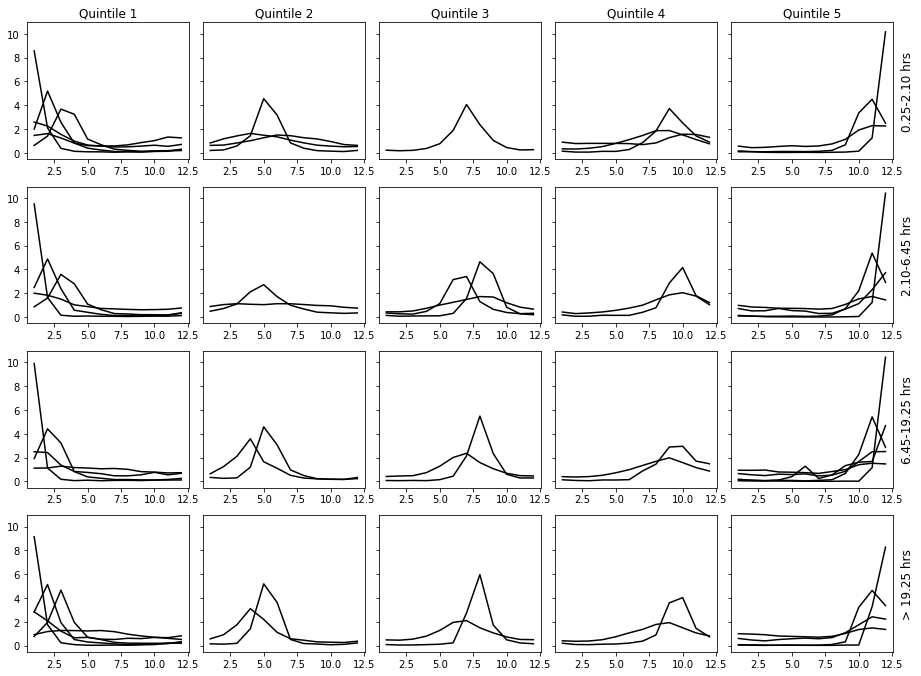

In [32]:
# Create the subplots
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13, 10), sharey=True)
plot_profiles_split_by_duration(axs, "NIMROD/NIMROD_1km_unfiltered_profiles", "NIMROD/NIMROD_1km_unfiltered_durations_for_profiles",
               "NIMROD/NIMROD_1km_unfiltered_volumes_for_profiles", "NIMROD/NIMROD_1km_unfiltered_real_durations_for_profiles",
              (0.25, 2.10), 0, color='black', linestyle='solid')
plot_profiles_split_by_duration(axs, "NIMROD/NIMROD_1km_unfiltered_profiles", "NIMROD/NIMROD_1km_unfiltered_durations_for_profiles",
               "NIMROD/NIMROD_1km_unfiltered_volumes_for_profiles","NIMROD/NIMROD_1km_unfiltered_real_durations_for_profiles",
              (2.10, 6.45),1,color='black', linestyle='solid')
plot_profiles_split_by_duration(axs, "NIMROD/NIMROD_1km_unfiltered_profiles", "NIMROD/NIMROD_1km_unfiltered_durations_for_profiles",
               "NIMROD/NIMROD_1km_unfiltered_volumes_for_profiles",  "NIMROD/NIMROD_1km_unfiltered_real_durations_for_profiles",
              (6.45, 19.25),2,color='black', linestyle='solid') 
plot_profiles_split_by_duration(axs, "NIMROD/NIMROD_1km_unfiltered_profiles", "NIMROD/NIMROD_1km_unfiltered_durations_for_profiles",
               "NIMROD/NIMROD_1km_unfiltered_volumes_for_profiles",  "NIMROD/NIMROD_1km_unfiltered_real_durations_for_profiles",
              (19.25, float('inf')),3,color='black', linestyle='solid') 

annotations = ["0.25-2.10 hrs", "2.10-6.45 hrs", "6.45-19.25 hrs", "> 19.25 hrs"]
for row in range(4):
    axs[row, -1].annotate(annotations[row], xy=(1.05, 0.5), xycoords='axes fraction',
                          fontsize='large', ha='left', va='center', rotation=90)

# Adjust the layout to make space for the annotations
fig.tight_layout(rect=[0, 0, 1, 0.95])


### Compare NIMROD to RVH profiles for one duration

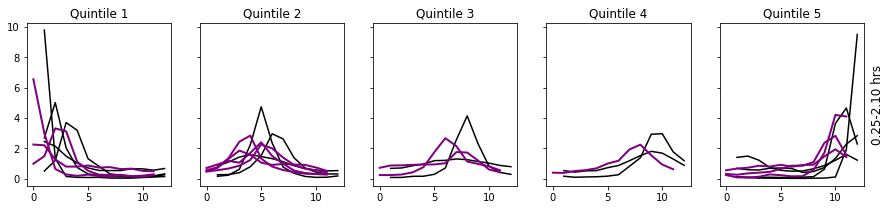

In [51]:
fig, axs = plt.subplots(ncols=5,figsize=(15, 3), sharey=True)
plot_profiles_onerow_oneduration(axs, "NIMROD/NIMROD_1km_filtered_100_profiles", "NIMROD/NIMROD_1km_filtered_100_durations_for_profiles",
               "NIMROD/NIMROD_1km_filtered_100_volumes_for_profiles", "NIMROD/NIMROD_1km_filtered_100_real_durations_for_profiles",
              (0.25, 2.10), color='black', linestyle='solid')

for cluster_num in range(1,14):
    cluster1=rvh_profiles[rvh_profiles['Cluster']==cluster_num]
    cluster1 = cluster1[:-2]
    quintile_with_max_value = find_quintile_with_max_value(np.array(cluster1['Mean']))
    axs[quintile_with_max_value].plot(range(len(cluster1)),cluster1['Mean'], linewidth = 2, color='purple')  
    
axs[-1].annotate("0.25-2.10 hrs", xy=(1.05, 0.5), xycoords='axes fraction',
                      fontsize='large', ha='left', va='center', rotation=90);